# Week 5 - Trees and Sankoff

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

This week we'll implement the Sankoff algorithm as seen in the Week4 lecture. This is a good introduction to programming with phylogenetic trees and NetworkX package.
    
</div>

## Setup

Make sure you have `python >= 3.10`. Check using `python --version` or `python3 --version`.

**Week 5 packages**

This week we will use:
- networkx
- ipykernel
- matplotlib

In [ ]:
# Import Necessary Packages
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## Building Trees

### Introduction to NetworkX Package

"NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks."

Official tutorials can be found in this [link](https://networkx.org/documentation/stable/tutorial.html).

Create an empty directed graph with no nodes and no edges (as trees are a special directed graph):

In [ ]:
# Directed graph
G = nx.DiGraph()
G

You can add nodes to a graph using a list (or an iterator).

In [ ]:
G.add_node(1)
G.add_nodes_from([2, 3])

You can also store attributes inside nodes

In [ ]:
# Add a node 4, and store a matrix in that node
G.add_node(4, matrix = np.zeros(shape = (4, 4)))
# Get the matrix in node 4
G.nodes[4]['matrix']

**Note:** The matrix is a reference. You can assign the reference (pointer) to a new variable, and modify the actual matrix in the graph.

In [ ]:
mat_4 = G.nodes[4]['matrix']
mat_4[0, 0] = 1
G.nodes[4]['matrix']

Edges can be added one at a time.

In [ ]:
G.add_edge(1, 2)

We can check the elements of a graph using the following:

In [ ]:
# Get all nodes in graph G
list(G.nodes)

In [ ]:
# Get all edges in graph G
list(G.edges)

In [ ]:
# Get all successsors (children) of node 1
list(G.successors(1))

### Creating the substitution matrix
First, we will create the $c_{ij}$ matrix that contains the substitution scores. As we saw in lecture, the score for no change is 0, the score for a trasition is 1.0 and the score for a transversion is 2.5.

We could hard code this since it's only 4x4 but here is some code that will build the matrix as a numpy matrix. The nuclei to integer index mapping are hard coded as a dictionary.

In [ ]:
# Define nucleotides and index mapping
CHARACTERS = ["A", "C", "G", "T"]
idx = {nt:i for i,nt in enumerate(CHARACTERS)}

# Build cost matrix (default = 2.5, transitions = 1, identity = 0)
cost_mat = np.full((4,4), 2.5)
cost_mat[idx['A'], idx['G']] = cost_mat[idx['G'], idx['A']] = 1.0
cost_mat[idx['C'], idx['T']] = cost_mat[idx['T'], idx['C']] = 1.0
np.fill_diagonal(cost_mat, 0.0)


print("The Cost Matrix:")
print(cost_mat)

In practical terms, this allows us to easily get a specific $c_{ij}$ value using matrix indices, which improves code readability and have optimal performance.

In [ ]:
print("The cost of A to C is:", cost_mat[idx['A'], idx['C']])

### Initializing the tree

We will also implement the tree as a directed NetworksX graph. The node names are tips, internals, or root. Tree branches are stored as directed edges in the graph object. The value matrix is stored in each node as an attribute.

The following function creates an empty directed graph object (or a tree) suitable for running the Sankoff algorithm on DNA data with the correct number of nodes given a number of tips.

In [ ]:
def init_tree(num_seq):
    """
    Create an empty tree with the tip initialized.
    The tree is not connected, but the number of nodes is correct
    """
    G = nx.DiGraph()
    # Create a matrix full of zeros (Not initialized)
    initial_mat = np.zeros((4, 1))

    # Create all tip nodes
    for i in range(num_seq):
        # Construct the tip name
        tip_name = f'tip{i}'
        # Add the tip node
        G.add_node(tip_name, matrix = initial_mat.copy())

    # Create all internal nodes, starting from internal 1
    for i in range(1, num_seq - 1, 1):
        node_name = f'internal{i}'
        G.add_node(node_name, matrix = initial_mat.copy())

    # Add the root node
    G.add_node("root", matrix = initial_mat.copy())

    return G

In [ ]:
# Test the init_tree() function
my_tree = init_tree(len('CACAG'))
print(my_tree.nodes['tip0']['matrix']) # Should output [[inf], [0], [inf], [inf]]
# Plot the unconnected graph
nx.draw(my_tree, with_labels=True)

### Exercise 1: Initializing tip values

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

<b>Challenge:</b> The following function should initialize a tip node for the Sankoff algorithm to 0 for the observed nucleotide and infinity (`np.inf`) for others. Try to complete it. Note that the function modifies the tree in-place and does not return a value.

- [ ] Initialize observed nucleotides with cost of zero
- [ ] initialize unobserved nucleotides with cost of infinity
- [ ] Return None

Hint:

- [ ] use `idx[observed_nt]` to get the index for the nucleotide

</div>

In [ ]:
def init_tip(tree, tip_name, observed_nt):
    """
    Intialise a tip of a tree with the correct costs.
    At this tip node, only the observed nucleotides are possible:
    the cost of the observed nucleotide is zero, and
    the cost of any other nucleotide is infinity.
    """
    # YOUR CODE HERE
    raise NotImplementedError

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;"></div>

Test your function

In [ ]:
# The first bases of all sequences
tip_seq = 'CACAG'
# Initialize tip0
tip_id = 0
tip_name = f"tip{tip_id}"
tip_base = tip_seq[tip_id]
init_tip(my_tree, tip_name, tip_base)
my_tree.nodes[tip_name]['matrix'] # Should output [[inf], [0], [inf], [inf]]

Bellow code explicitly sets the tree topology. We can change the tree's structure by modifying these lines.

In [ ]:
my_tree.add_edge("internal1", "tip0")
my_tree.add_edge("internal1", "tip1")
my_tree.add_edge("internal2", "tip3")
my_tree.add_edge("internal2", "tip4")
my_tree.add_edge("internal3", "tip2")
my_tree.add_edge("internal3", "internal2")
my_tree.add_edge("root", "internal1")
my_tree.add_edge("root", "internal3")

# Plot the tree
nx.draw(my_tree, with_labels=True)

The plot might look nasty, but the structure is correct.

This is because networkx defaults to 'spring_layout' when drawing graphs. These different layout methods have a huge impact on the visual interpretation of graph data. The 'spring_layout' algorithm is an optimiser which solves node coordinates by balances two forces. 1) edges attract connected nodes, and 2) nodes repel other nodes. This layout algorithm has merit for some graphs, but clearly not for binary trees!

The code below replaces 'spring_layout' for a tree-specific layout algorithm. 
The best networkx layout for binary trees is graphviz_layout(Graph, prog='dot'), but requires installing pygraphviz in your environment (using using pip/conda).
If having difficulties with this, the code will use 'bfs_layout' as a fallback.


In [ ]:
plt.figure(figsize=(6, 5))
try:
    pos = nx.drawing.nx_agraph.graphviz_layout(my_tree, prog='dot')
    print("Using graphviz_layout(prog='dot')")
except ImportError:
    pos = nx.bfs_layout(my_tree, start='root')
    print("Using bfs_layout")
nx.draw_networkx_nodes(my_tree, pos, node_color='skyblue', node_size=2000)
nx.draw_networkx_edges(my_tree, pos, min_target_margin=23, edge_color='gray')
nx.draw_networkx_labels(my_tree, pos, font_size=10, font_color='black')
plt.show()

Following loop uses the helpful builtin function `enumerate` to initialize the tips of the tree using the function you wrote above. Double check that it is working correctly for the tip sequence you entered.

In [ ]:
for i, nt in enumerate(tip_seq):
    tip_name = 'tip{}'.format(i)
    init_tip(my_tree, tip_name, nt)
    print(f"{tip_name} is {nt}, and the matrix is:")
    print(tip_name)
    print(my_tree.nodes[tip_name]['matrix'])

## Scoring trees

### Exercise 2: Sankoff function core calculation


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

This function calculates the $S$ arrays for each node. It assumes that the left and right nodes have already been filled.

The outer loop is looping over the four entries (ACGT) in the $S$ array. 
    
<b>Challange:</b> Complete the function using the variables initialized and the calculation from lecture:

$S_a(i) = \min_{j}[c_{ij} + S_L(j)] + \min_{k}[c_{ik} + S_R(k)]$

As before, this function modifies the tree in place and doesn't return a value.

Hint:

- [ ] use `list(my_tree.successors(node_name))` to get the successors of a node
    
</div>

In [ ]:
def sankoff_calculate(cost_matrix, tree, node_name):
    """
    For the specified node of the tree, calculate the minimum possible cost 
    for each nucleotide. 
    """

    # YOUR CODE HERE
    raise NotImplementedError

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;"></div>

Since the `sankoff_calculate` function requires that the left and right nodes be populated, we will perform a recursive traversal. 

In [ ]:
def sankoff_traverse(c_matrix, tree, node_name):
    """
    Traverse the tree recursively, calculating costs for each node.
    Calculate a node's children before the node itself.
    This function depends on correctly initialising the costs in the tips
    of the tree before traversing the tree.
    """
    children = list(tree.successors(node_name))
    if len(children) <= 0:
        return None
    if len(children) != 2:
        raise Exception("Incorrect binary tree")
    left_node = children[0]
    right_node = children[1]
    # Traverse left and right node
    sankoff_traverse(c_matrix, tree, left_node)
    sankoff_traverse(c_matrix, tree, right_node)
    sankoff_calculate(c_matrix, tree, node_name)

In [ ]:
sankoff_traverse(cost_mat, my_tree, 'root')

Finally, we can print the result of the root node.

In [ ]:
my_tree.nodes["root"]['matrix']

Finding the minimum cost

In [ ]:
root_mat = my_tree.nodes["root"]['matrix']

min_cost = root_mat.min()
min_locs = np.where(root_mat == min_cost)

min_nts = []
for loc in min_locs:
    min_nts.append(CHARACTERS[loc[1]])

print("Minimum cost is {} for {}".format(min_cost, " and ".join(min_nts)))

## Extension: Maximum Parsimony

The material above uses Sankoff to score a single column of an input MSA for a predefined tree structure. In this section you will extend this to Maximum Parsimony by using a full MSA and scoring multiple trees. 

Your task is to identify which of the following trees is best at explaining the observed organism sequences (the MSA). 


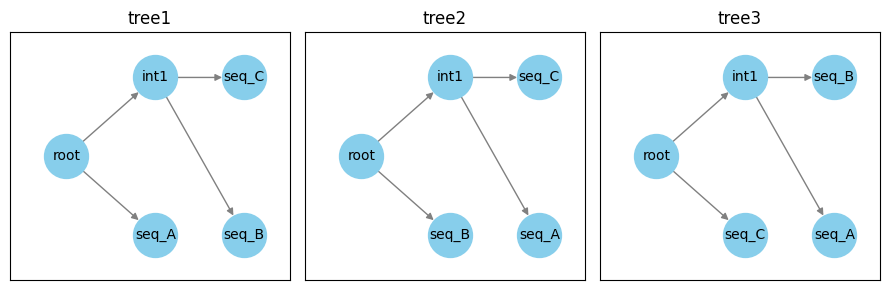

In [ ]:
MSA = {
    'seq_A': 'GATTACA',
    'seq_B': 'GA-TAGC',
    'seq_C': 'GA-AAGC',
}

tree1 = nx.DiGraph()
tree1.add_edge('root', 'seq_A')
tree1.add_edge('root', 'int1')
tree1.add_edge('int1', 'seq_B')
tree1.add_edge('int1', 'seq_C')

tree2 = nx.DiGraph()
tree2.add_edge('root', 'seq_B')
tree2.add_edge('root', 'int1')
tree2.add_edge('int1', 'seq_A')
tree2.add_edge('int1', 'seq_C')

tree3 = nx.DiGraph()
tree3.add_edge('root', 'seq_C')
tree3.add_edge('root', 'int1')
tree3.add_edge('int1', 'seq_A')
tree3.add_edge('int1', 'seq_B')

all_labels = ['tree1', 'tree2', 'tree3']
all_trees = [tree1, tree2, tree3]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
for ax, label, the_tree in zip(axes, all_labels, all_trees):
    pos = nx.bfs_layout(the_tree, start='root')
    nx.draw_networkx_nodes(the_tree, pos, node_color='skyblue', node_size=1000, ax=ax)
    nx.draw_networkx_edges(the_tree, pos, min_target_margin=16, edge_color='gray', ax=ax)
    nx.draw_networkx_labels(the_tree, pos, font_size=10, font_color='black', ax=ax)
    # networkx is annoying - sometimes nodes are partially off the canvas. This handles it. 
    ax.set_xlim([1.3*x for x in ax.get_xlim()])
    ax.set_ylim([1.3*y for y in ax.get_ylim()])
    ax.set_title(label)

plt.tight_layout()
plt.show()

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">
   
<b>Challenge</b>: Calculate the Parsimony Length ***L(T)*** of a given tree for the full MSA. 

Use your previously defined `init_tip` and `sankoff_traverse()` functions. 

New considerations
- The parsimony length of a given tree using a full MSA, *L(T)* is the sum of individual Sankoff scores (one per MSA column). 
- As there are 7 columns of the MSA, you will run `init_tip` and `sankoff_traverse()` 7 times. 
- You can choose to use the same networkx graph for each run, or create a copy. Both work. 
- For each Sankoff run, make sure to extract the minimum cost of the root node matrix and add to the running sum.

</div>

In [ ]:
def calculate_tree_parsimony(msa: dict, tree: nx.DiGraph) -> float:
    ### YOUR CODE HERE
    raise NotImplementedError


You can now use your `calculate_tree_parsimony()` function above to assess each tree and identify the best. 

In [ ]:
all_trees = [tree1, tree2, tree3]
all_labels = ['tree1', 'tree2', 'tree3']
all_scores = []

### YOUR CODE HERE
raise NotImplementedError